In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as la

from halton import *

#sparse matrices
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.spatial import cKDTree

#ploting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import griddata


from scipy.sparse.linalg import bicgstab, bicg, spilu, LinearOperator, gmres

from scipy.sparse.csgraph import reverse_cuthill_mckee as rcm

In [2]:
def poly_basis(k):
    ret = []
    deg = 0
    while len(ret)<k:
        for i in range(deg+1):
            ret += [lambda x, i=i, deg=deg, : x[0]**(deg-i) * x[1]**i]
        deg += 1
    return ret[:k]

def poly_basis_L(k):
    ret = []
    deg = 0
    while len(ret)<k:
        for i in range(deg+1):
            ret += [lambda x, i=i, deg=deg, : 
                      (deg-i)*(deg-i-1)*x[0]**(deg-i-2) * x[1]**i 
                    + x[0]**(deg-i) * i*(i-1)*x[1]**(i-2)
                   ]
        deg += 1
    return ret[:k]

In [3]:
def dist(x, y):
    return np.sqrt((x[0]-y[0])**2 + ([1]-y[1])**2)

def rbf0(r):
    return r**3
def rbf0d(r):
    return 6*r

def rbf1(r):
    return r**7
def rbf1d(r):
    return 42*r**7

eps = .3
def rbfGA(r):
    return np.exp(-eps*r**2)
#def rbfGAd(r):
    

In [4]:
def halton(n):
    inner_nodes = halton_sequence(1,n,2).T
    inner_nodes = np.array([(np.sqrt(x)*np.cos(2*np.pi*y), 
                             np.sqrt(x)*np.sin(2*np.pi*y)) 
                            for (x,y) in inner_nodes])
    return inner_nodes

def vogel(n):
    theta_hat = np.pi*(3-np.sqrt(5))
    inner_nodes = np.array([ (np.sqrt(i/n)*np.cos(i*theta_hat), 
                              np.sqrt(i/n)*np.sin(i*theta_hat)) for i in range(1,n+1)])
    return inner_nodes

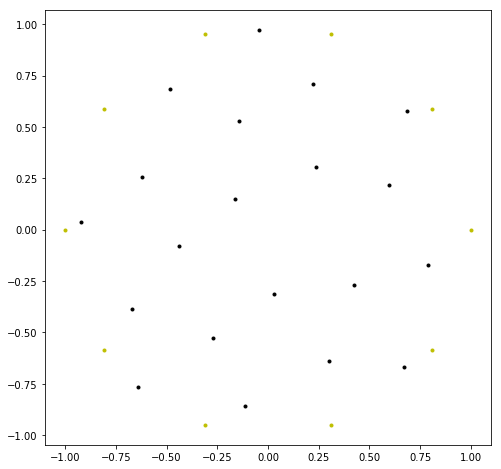

In [5]:
n = 20
n_b = 10

inner_nodes = vogel(n)
                           
theta = np.linspace(0, 2*np.pi, n_b, endpoint=False)
boundary_nodes = np.array([np.cos(theta), np.sin(theta)]).T

nodes = np.concatenate((inner_nodes, boundary_nodes), axis=0)
tree = cKDTree(nodes)

plt.figure(figsize=(8,8))
plt.plot(inner_nodes[:,0], inner_nodes[:,1], 'k.')
plt.plot(boundary_nodes[:,0], boundary_nodes[:,1], 'y.')

In [6]:
def boundary(x):
    return x[0]

rbf = lambda x,y: rbf1(dist(x,y))
rbfd = lambda x,y: rbf1d(dist(x,y))

k = 5 #stencil size
pdim = 3

#*****************************************
n = len(inner_nodes)
n_b = len(boundary_nodes)


pbasis = poly_basis(pdim)
pbasisL = poly_basis_L(pdim)
weights = np.zeros((n, k))
#row_index = []
row_index = [r for r in range(n) for c in range(k)]
col_index = np.zeros((n, k))
for r in range(n):
    n_index = tree.query(nodes[r], k)[1]
    neighbors = [nodes[i] for i in n_index]
    A = np.array([[rbf(x,y) for x in neighbors] for y in neighbors]).reshape((k,k))
    P = np.array([[p(x) for p in pbasis] for x in neighbors])
    AP = np.block([[A.reshape((k,k)), P],[P.T, np.zeros((pdim,pdim))]])
    rhs = np.array([rbfd(nodes[r], nodes[i]) for i in n_index])
    rhsp = np.array([pd(nodes[r]) for pd in pbasisL])
    rhs = np.block([rhs.ravel(), rhsp.ravel()])
    #rhs = np.block([rhs.ravel(), np.zeros(pdim)])
    #rhs[k] = 1
    #rhs[k+1] = 1
    #rhs[k+2] = 1
    #weights[r] = la.solve(AP, rhs)[:k]
    weights[r] = (la.pinv(AP)@rhs)[:k]
    col_index[r] = n_index
    
C = sp.csr_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n+n_b))

b_vec = np.array([-boundary(x) for x in boundary_nodes])

u = spsolve(C[:,:n], C[:,n:]@b_vec)
u = np.concatenate((u.ravel(), -b_vec.ravel()), axis=0)
    


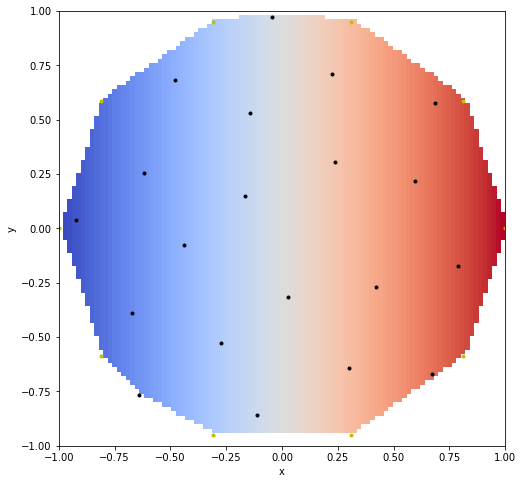

max 1.000000
min -1.000000
ave -0.018835


In [7]:
x1 = nodes[:,0]
x2 = nodes[:,1]


# define grid.
xi = np.linspace(-1,1,100)
yi = np.linspace(-1,1,100)
# grid the data.

zi = griddata((x1, x2), u, (xi[None,:], yi[:,None]), method='cubic')
#zi = np.nan_to_num(zi)
zi = np.ma.masked_invalid(zi)

X, Y = np.meshgrid(xi, yi)

plt.figure(figsize=(8,8))
plt.pcolormesh(X,Y,zi, cmap=cm.coolwarm)
plt.plot(inner_nodes[:,0], inner_nodes[:,1], 'k.')
plt.plot(boundary_nodes[:,0], boundary_nodes[:,1], 'y.')

plt.xlabel('x')
plt.ylabel('y')

plt.show()
print('max %f' % np.max(u))
print('min %f' % np.min(u))
print('ave %f' % np.average(u))

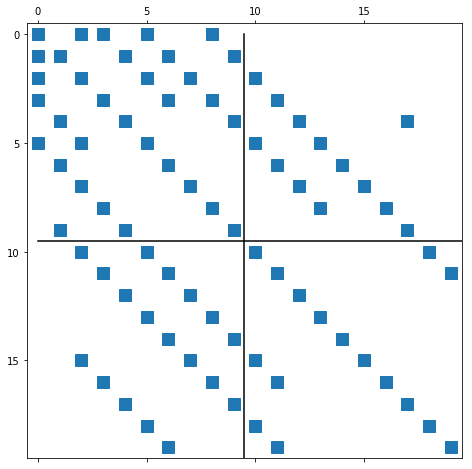

In [8]:
plt.figure(figsize=(8,8))
plt.spy(C[:,:n], markersize=12)
#plt.spy(C, markersize=3)
plt.plot((9.5,9.5), (0,20), 'k-')
plt.plot( (0,20),(9.5,9.5), 'k-')

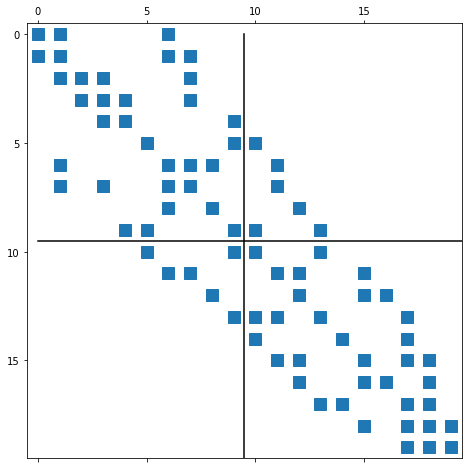

In [9]:
perm = rcm(C[:,:n])
old = C[:,:n].todense()
new = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        new[i,j] = old[perm[i], perm[j]]
        
new = sp.csr_matrix(new)

plt.figure(figsize=(8,8))
plt.spy(new, markersize=12)
plt.plot((9.5,9.5), (0,20), 'k-')
plt.plot( (0,20),(9.5,9.5), 'k-')        

In [10]:
perm
old = C.todense()


In [11]:
np.max(np.abs(u - nodes[:,0]))

1.0103029524088925e-14

In [12]:
A = C[:,:n]
b = C[:,n:]@b_vec

In [13]:
x = spsolve(A,b)

In [14]:
(A@x).shape

(20,)

In [15]:
la.norm(b - A@x)/len(b)

1.169624776918819e-12

In [16]:
ilu_A = spilu(A)
M_solve = lambda x: ilu_A.solve(x)
#M_solve = lambda x: np.dot(np.eye(n,n), x)
M = LinearOperator((n,n), M_solve)
x, info = bicgstab(A, b, M=M, tol=1e-10)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:370: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [17]:
print(la.norm(b - A@x))
print(info)

1.516185579648736e-11
0


In [18]:
ilu_A = spilu(A)
M_solve = lambda x: ilu_A.solve(x)
#M_solve = lambda x: x
M = LinearOperator((n,n), M_solve)
x, info = gmres(A, b, M=M, tol=1e-10)
print(la.norm(b - A@x))
print(info)

4.386683003421224e-11
0


/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:370: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [19]:
#******************************************************
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#******************************************************

# 1-D testing

In [20]:
#*********************************************************
#
# RBFs
#
#*********************************************************
def rbf_0(r):
    return np.abs(r)**5
def rbf_d2_0(r):
    return 20*np.abs(r)**3

def rbf_1(r):
    return 1/(1+r**2)
    #return np.exp(-r)
def rbf_d2_1(r):
    return 8*r**2/(1+r**2)**3 - 2/(1+r**2)**2
    

#*********************************************************
#
# Polynomial Basis
#
#*********************************************************
def poly_basis(terms):
    ret = []
    for i in range(terms):
        ret += [lambda x, i=i: x**i]
    return ret
    
def poly_basis_L(terms):
    ret = [lambda x: 0]
    if terms == 1:
        return ret
    ret += [lambda x: 1]
    if terms == 2:
        return ret
    for i in range(2,terms):
        ret += [lambda x, i=i: i*(i-1)*x**(i-2)]
    return ret

#*********************************************************
#
# Nearest
#
#*********************************************************

def get_nearest(lst, index, num):
    if index==0:
        return range(num)
    elif index==len(lst)-1:
        return range(len(lst)-1,len(lst)-num-1, -1)
    ret = [index]
    above = index+1
    below = index-1
    for i in range(num-1):
        dist_up = np.abs(lst[index] - lst[above])
        dist_dn = np.abs(lst[index] - lst[below])
        if dist_up < dist_dn:
            ret += [above]
            above += 1
            above %= len(lst)
            dist_up = np.abs(lst[index] - lst[above])
        else:
            ret += [below]
            below -= 1
            below %= len(lst)
            dist_dn = np.abs(lst[index] - lst[below])
    return ret


def get_halton(n):
    nodes = halton_sequence(1,n-2,1).ravel()
    #add two boundary nodes
    nodes = np.pad(nodes, (1,1), 'constant', constant_values=(0))
    nodes[0] = 0 
    nodes[-1] = 1
    return nodes

#*********************************************************
#
# Some forcing functions
#
#*********************************************************
def forcing0(x):
    return 0

def forcing1(x):
    return 20*np.sin(3*np.pi*x)

def forcing2(x):
    return x*(1-x)*20

def forcing3(x): #discontinuous
    if .45<x and x<.55:
        return 5
    else:
        return 0

def forcing4(x): #non-smooth
    amplitude = 20
    if x<.5:
        return 20*x
    else:
        return 20*(1-x)
    
def forcing5(x): #second derivative non-smooth
    if x < .5:
        return 0
    else:
        return (x-.5)**2 * 30


In [21]:
#parameters *****************************************************
forcing = forcing1
rbf, rbf_d2 = rbf_0, rbf_d2_0
a=2
b=3
n = 200
k = 10
terms = 3

# Generate nodes ************************************************

#nodes = np.linspace(0,1, n)
nodes = get_halton(n)

# Construct poly basis ******************************************
basis = poly_basis(terms)
basis_L = poly_basis_L(terms)

# Construct the differentiation matrix **************************

weights = np.zeros((n,k))
row_index = [r for r in range(n) for c in range(k)]
col_index = np.zeros((n, k))

for r in range(n):
    nnid = get_nearest(nodes, r, k)
    nbrs = [nodes[i] for i in nnid]
    A = np.array([[rbf(x1 - x2) for x1 in nbrs] for x2 in nbrs])
    P = np.array([[p(x) for p in basis] for x in nbrs])
    AP = np.block([[A, P],[P.T, np.zeros((terms,terms))]])
    b_vec = [rbf_d2(x - nodes[r]) for x in nbrs]
    b_vec += [p_L(nodes[r]) for p_L in basis_L]
    b_vec = np.array(b_vec)
    weights[r] = la.solve(AP, b_vec)[:k]
    col_index[r] = nnid
    
D = sp.csr_matrix( (weights.ravel(), (row_index, col_index.ravel())), shape=(n,n) )
    




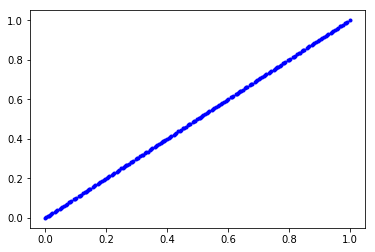

In [22]:
plt.plot(nodes,nodes, 'b.')

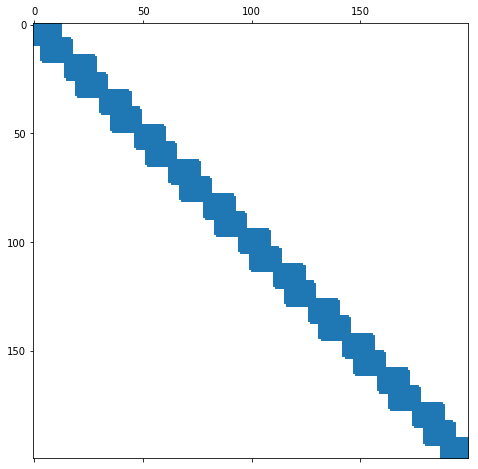

In [23]:
plt.figure(figsize=(8,8))
plt.spy(D)

In [24]:
row_index

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,


In [25]:
row_index = [r for r in range(n) for c in range(k)]
print(row_index)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,